<a href="https://colab.research.google.com/github/tanupunjani/Mastering-tensorflow/blob/main/Transfer_learning_with_tensorflow_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning - scaling up

After feature extraction and fine-tuning our transfer learning model, we need to scale up all of our food101 classes.

Our goal is to beat the food vision 101 paper

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-19 17:28:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-19 17:28:15 (68.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
#Import series of helper functions for our notebook 
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

#101 Food classes : working with less data

Our goal is to beat Food 101 paper with 10% of the training data so lets download it 

In [3]:

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-08-19 17:28:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   105MB/s    in 14s     

2021-08-19 17:28:32 (111 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
#Checking the classes 
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ravioli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hummus'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/edamame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '10

In [5]:
#Setup data inputs
import tensorflow as tf
Image_size = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=Image_size)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=Image_size,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


#Training a big dog model with transfer learning on 10% of 101 food classes

Steps that we are taking

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the layer
* Build a headless(no top layers) Functional EffecientNetB0 backboned model (we'll create our own output layers)
* Compile our model
* Feature extract for full 5 passes(5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [6]:
#Create a model checkpoint
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor = "val_accuracy",
                                                         save_best_only=True)

#It will save the lowest accuracy weights only 

In [7]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [8]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [9]:

# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [10]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 149s 484ms/step - loss: 3.4656 - accuracy: 0.2503 - val_loss: 2.6672 - val_accuracy: 0.4031
Epoch 2/5
237/237 [==============================] - 90s 378ms/step - loss: 2.3572 - accuracy: 0.4569 - val_loss: 2.1934 - val_accuracy: 0.4754
Epoch 3/5
237/237 [==============================] - 86s 360ms/step - loss: 1.9797 - accuracy: 0.5316 - val_loss: 2.0434 - val_accuracy: 0.4950
Epoch 4/5
237/237 [==============================] - 79s 330ms/step - loss: 1.7565 - accuracy: 0.5720 - val_loss: 1.9282 - val_accuracy: 0.5114
Epoch 5/5
237/237 [==============================] - 72s 300ms/step - loss: 1.6073 - accuracy: 0.6107 - val_loss: 1.9064 - val_accuracy: 0.5093


#In the next steps we are going to use fine-tuning. We unfreeze only the top layers because the bottom layers learn large features of the data while the top layers learn the finely ground features

In [11]:

# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 100s 126ms/step - loss: 1.7271 - accuracy: 0.5514


[1.7271174192428589, 0.5514455437660217]

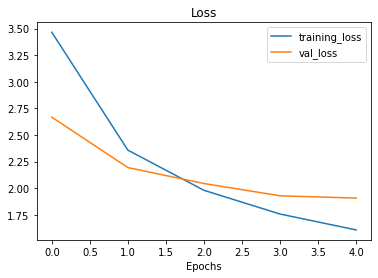

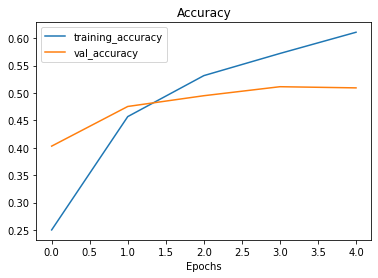

In [12]:
plot_loss_curves(history_all_classes_10_percent)

# Our model might be overfitting

# **Fine-tuning**

In [13]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [14]:
#recompile the model with lower learning rate (its the best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [16]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [17]:
#fine-tune for 5 more epochs
fine_tune_epochs = 10 #model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 82s 310ms/step - loss: 1.3529 - accuracy: 0.6495 - val_loss: 1.8950 - val_accuracy: 0.5029
Epoch 6/10
237/237 [==============================] - 71s 296ms/step - loss: 1.2129 - accuracy: 0.6808 - val_loss: 1.9037 - val_accuracy: 0.5109
Epoch 7/10
237/237 [==============================] - 68s 286ms/step - loss: 1.1503 - accuracy: 0.6969 - val_loss: 1.8925 - val_accuracy: 0.5138
Epoch 8/10
237/237 [==============================] - 64s 270ms/step - loss: 1.0653 - accuracy: 0.7188 - val_loss: 1.8714 - val_accuracy: 0.5220
Epoch 9/10
237/237 [==============================] - 63s 266ms/step - loss: 1.0150 - accuracy: 0.7335 - val_loss: 1.8326 - val_accuracy: 0.5328
Epoch 10/10
237/237 [==============================] - 60s 251ms/step - loss: 0.9754 - accuracy: 0.7399 - val_loss: 1.8494 - val_accuracy: 0.5267


In [18]:
#Evaluate with whole dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 98s 124ms/step - loss: 1.6301 - accuracy: 0.5728


[1.6301189661026, 0.5727524757385254]

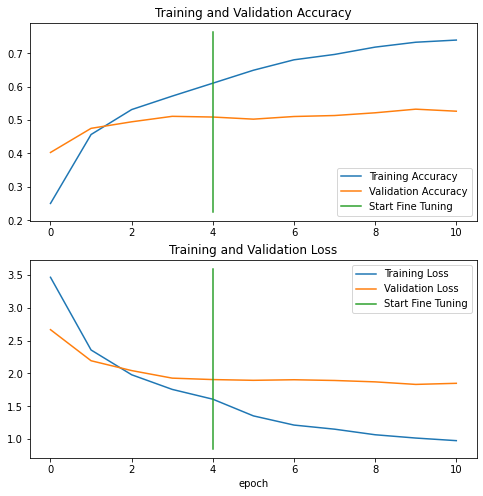

In [19]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

#**Saving and loading our model**

This step is used for exporting our model to be able to use in external applications

In [20]:
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [21]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [22]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 98s 124ms/step - loss: 1.6301 - accuracy: 0.5728


[1.6301189661026, 0.5727524757385254]

# **Making predictions with our trained model**

In [23]:
#Make predictions
preds_probs = model.predict(test_data, verbose=1) #set verbosity to see how long is left

790/790 [==============================] - 86s 107ms/step


In [24]:
len(test_data)

790

In [25]:
#How many predictions are there ?
len(preds_probs)

25250

In [26]:
#whats the shape of our predictions ?
preds_probs.shape

(25250, 101)

In [27]:
#check first 10 predictions
preds_probs[:10]

array([[3.6488301e-01, 5.8384139e-05, 2.0898017e-01, ..., 6.8355817e-05,
        2.2148648e-03, 7.8300849e-02],
       [8.7369913e-01, 4.0708460e-07, 2.7823607e-03, ..., 3.9133574e-03,
        6.4928599e-07, 2.7519582e-06],
       [1.9321616e-01, 4.3308856e-03, 5.4800701e-03, ..., 4.4213593e-04,
        2.7883160e-03, 1.9824572e-03],
       ...,
       [3.8391718e-01, 6.8128275e-06, 1.6991267e-03, ..., 2.8653441e-02,
        2.0242417e-04, 5.3327956e-05],
       [1.1587791e-01, 1.8532720e-03, 9.9376924e-02, ..., 3.5553306e-04,
        2.0053155e-04, 6.0503482e-04],
       [4.2486680e-01, 5.1723878e-06, 7.6359371e-04, ..., 4.0391795e-02,
        1.4444160e-05, 2.4760878e-03]], dtype=float32)

In [28]:
#What does the first prediction probabilty look like ?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.64883006e-01, 5.83841393e-05, 2.08980173e-01, 4.24776125e-08,
        5.71856663e-06, 4.42009338e-07, 1.19617813e-04, 4.60924412e-06,
        2.59542316e-02, 9.17644298e-04, 3.70958060e-06, 2.71492422e-06,
        5.70439966e-04, 3.41594813e-07, 2.87460089e-02, 1.03261031e-03,
        5.61334809e-06, 6.07642636e-04, 1.00497017e-03, 1.48176980e-06,
        1.21907760e-04, 3.66455024e-05, 4.52302542e-04, 1.87271289e-04,
        9.70693072e-05, 1.74404107e-04, 1.79870476e-04, 2.13163021e-05,
        8.89191106e-02, 4.58264165e-03, 5.93220238e-06, 9.99511452e-04,
        6.47727284e-04, 7.58851684e-08, 1.05743855e-02, 8.53772963e-06,
        3.24213936e-04, 6.32080424e-04, 1.84831675e-02, 1.46047796e-05,
        3.59538208e-05, 4.34982183e-04, 1.15156127e-03, 2.98841974e-06,
        1.95577122e-05, 3.36572266e-05, 5.45238785e-04, 2.82429479e-04,
        6.45006651e-07, 2.93988362e-02, 2.00145892e-04, 1.15451694e-05,
        3.12284604e-02, 1.38358818e-02, 3.63323693e-06, 2.171138

#Our model outputs a prediction probabilty array (with N number of variables where N is the number of classes) for each sample passed to the predict method.

In [29]:
#We get one prediction probability per class (in our case we have 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [3.64883006e-01 5.83841393e-05 2.08980173e-01 4.24776125e-08
 5.71856663e-06 4.42009338e-07 1.19617813e-04 4.60924412e-06
 2.59542316e-02 9.17644298e-04 3.70958060e-06 2.71492422e-06
 5.70439966e-04 3.41594813e-07 2.87460089e-02 1.03261031e-03
 5.61334809e-06 6.07642636e-04 1.00497017e-03 1.48176980e-06
 1.21907760e-04 3.66455024e-05 4.52302542e-04 1.87271289e-04
 9.70693072e-05 1.74404107e-04 1.79870476e-04 2.13163021e-05
 8.89191106e-02 4.58264165e-03 5.93220238e-06 9.99511452e-04
 6.47727284e-04 7.58851684e-08 1.05743855e-02 8.53772963e-06
 3.24213936e-04 6.32080424e-04 1.84831675e-02 1.46047796e-05
 3.59538208e-05 4.34982183e-04 1.15156127e-03 2.98841974e-06
 1.95577122e-05 3.36572266e-05 5.45238785e-04 2.82429479e-04
 6.45006651e-07 2.93988362e-02 2.00145892e-04 1.15451694e-05
 3.12284604e-02 1.38358818e-02 3.63323693e-06 2.17113867e-02
 1.66165456e-02 7.31463311e-04 2.93160952e-

In [30]:
#Get the pred classes of each label 
pred_classes = preds_probs.argmax(axis=1)

#How do they look ?
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29,  0,  9,  0])

In [31]:
#how many pred classes do we have ?
len(pred_classes)

25250

In [32]:
pred_classes.shape

(25250,)

#Now we have got a predictions array of all our model's predictions, to evaluate them, we need to compare them to the orignal datasets labels.

In [33]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [34]:

# How many y_labels are there?
len(y_labels)

25250

In [35]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [36]:
len(test_data)

790

#Evaluating our model's predictions

WE want to check if the model's prediction arrays are in the same order as the test labels array. One way to find this is to get the accuracy score

In [37]:
results_downloaded_model

[1.6301189661026, 0.5727524757385254]

In [38]:
#trying the scikit learn accuracy score function and see what it comes up with 
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.5727524752475247

In [39]:
#Does this metrci come close to our model's evaluate results 
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

#Visualizing : Confusion matrix

In [40]:
from helper_functions import make_confusion_matrix

In [41]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [42]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

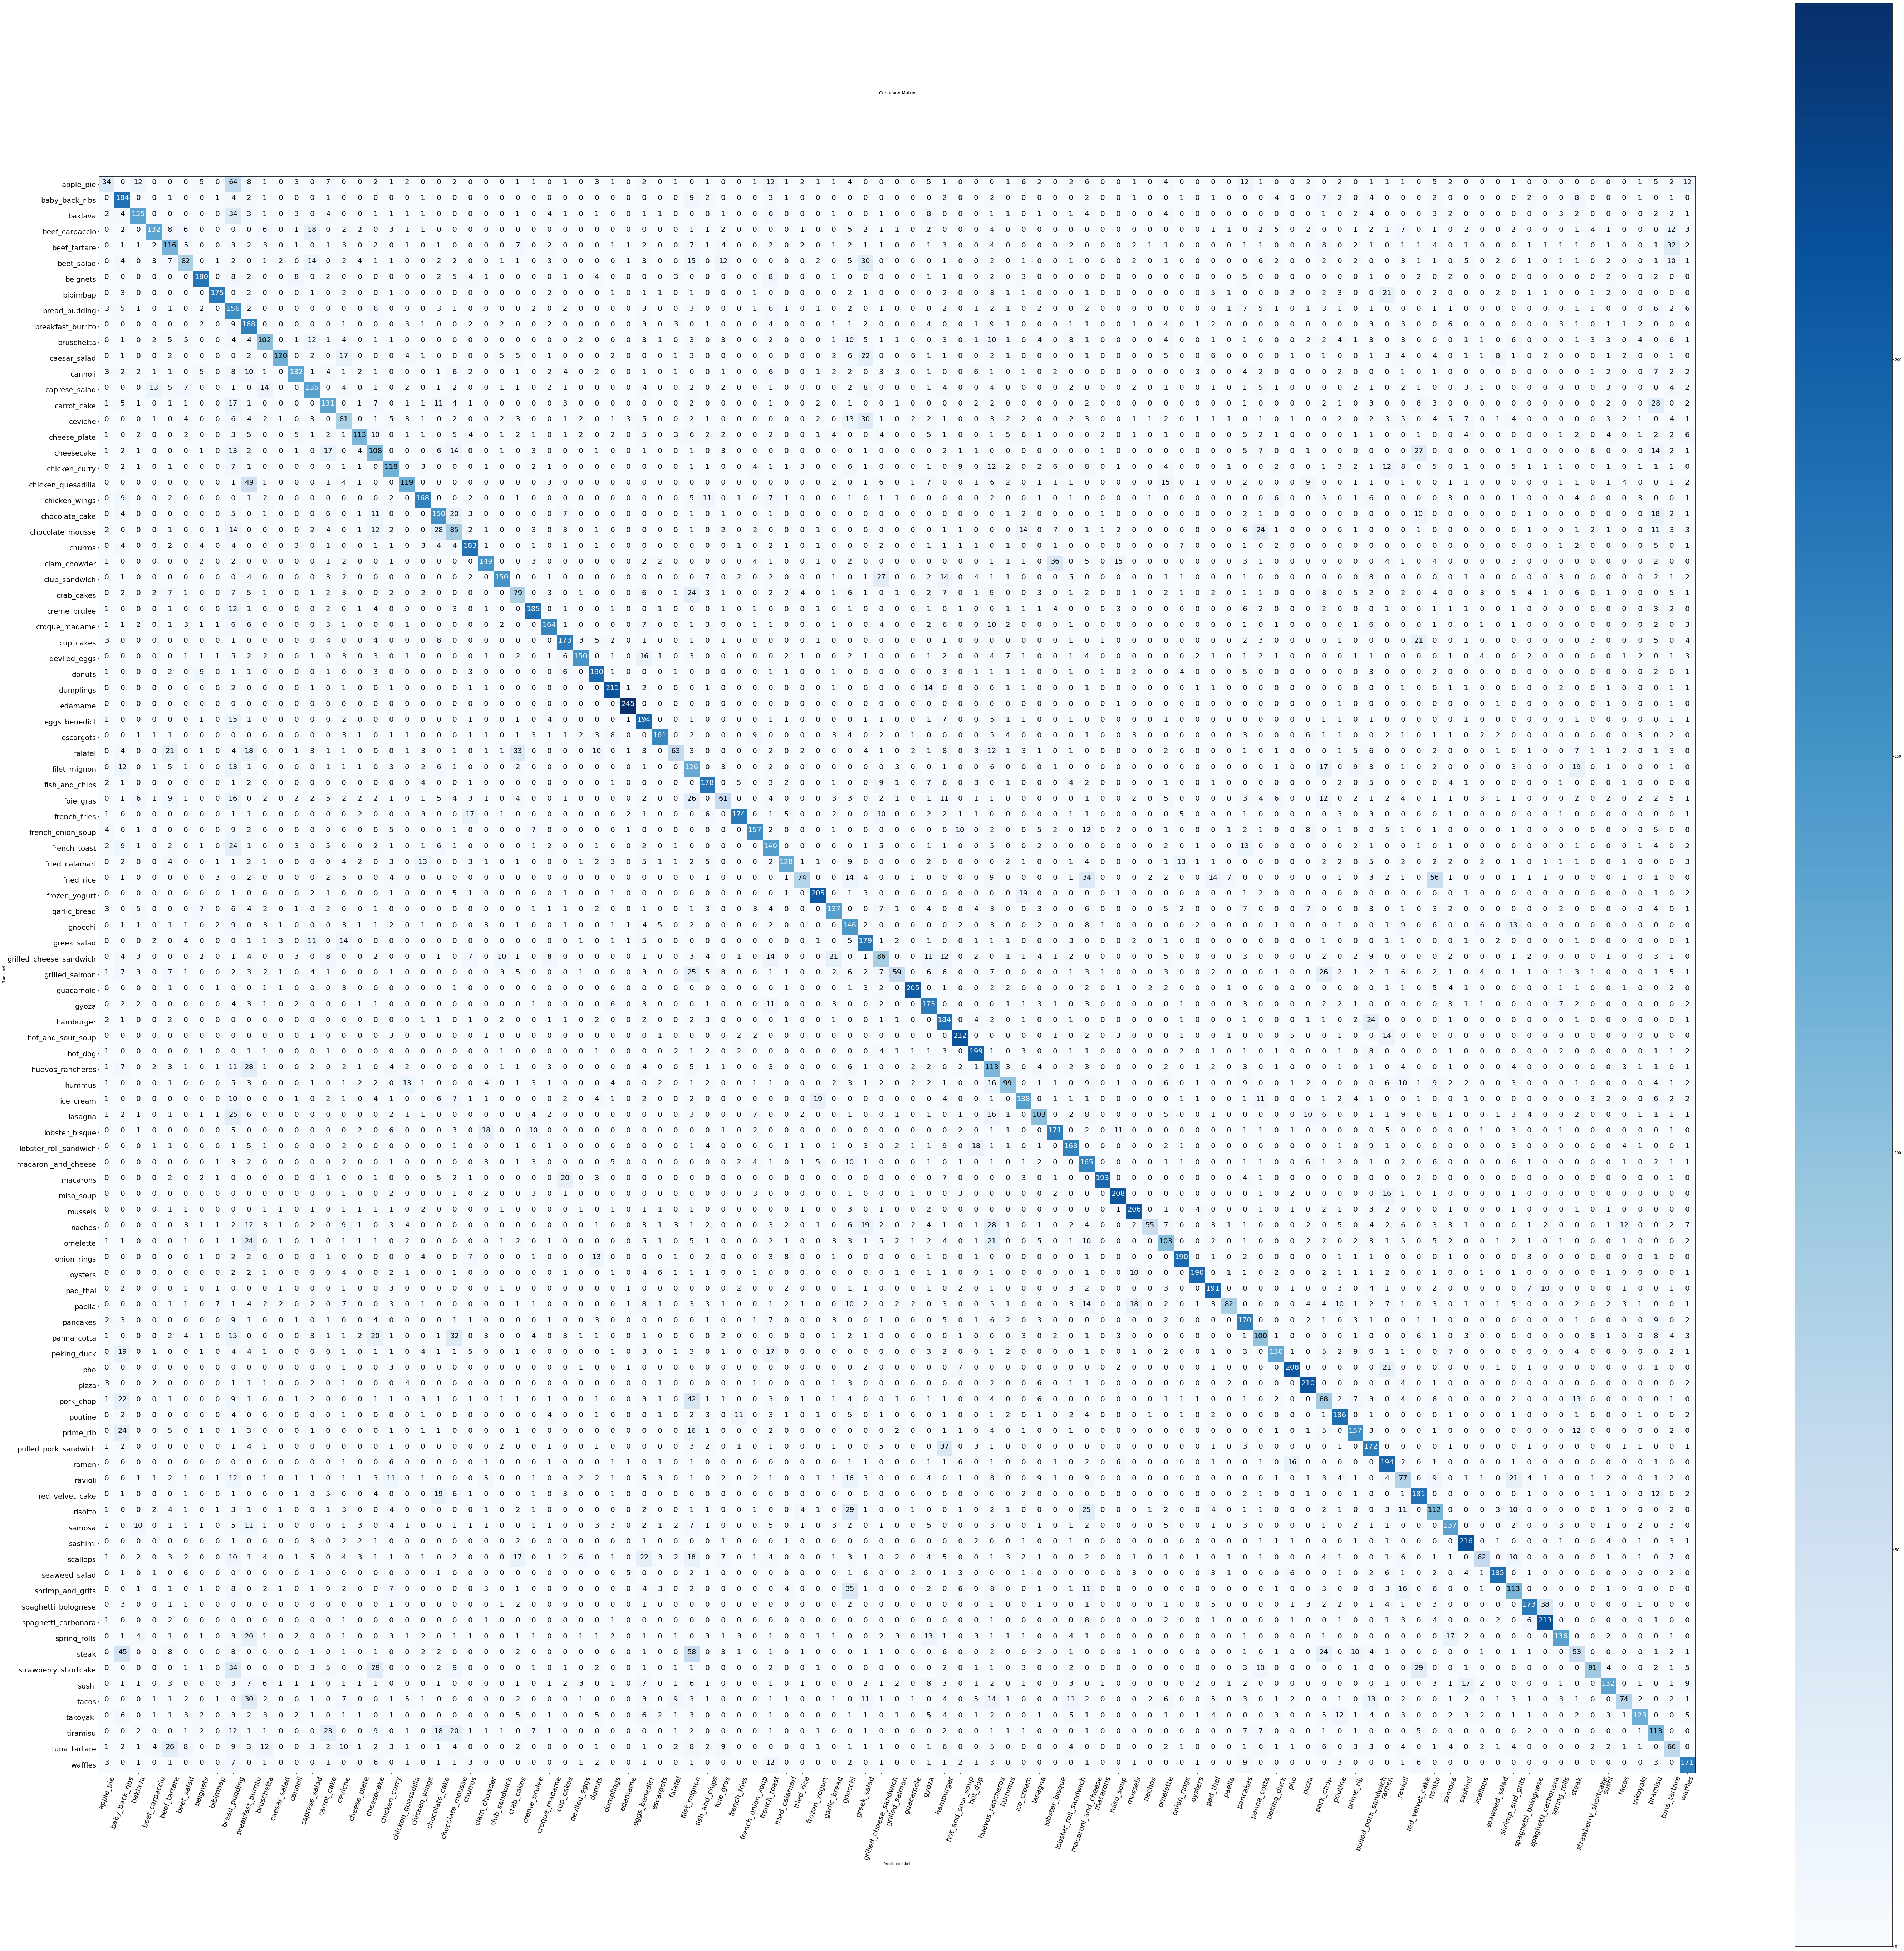

In [43]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

# Create a classification report

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.37      0.14      0.20       250
           1       0.43      0.74      0.54       250
           2       0.66      0.54      0.59       250
           3       0.75      0.53      0.62       250
           4       0.40      0.46      0.43       250
           5       0.50      0.33      0.40       250
           6       0.75      0.72      0.73       250
           7       0.86      0.70      0.77       250
           8       0.21      0.62      0.32       250
           9       0.33      0.67      0.44       250
          10       0.51      0.41      0.45       250
          11       0.87      0.48      0.62       250
          12       0.73      0.53      0.61       250
          13       0.53      0.54      0.54       250
          14       0.49      0.52      0.51       250
          15       0.33      0.32      0.33       250
          16       0.69      0.45      0.55       250
          17       0.39    

###The classification_report() outputs the precision, recall and f1-scores per class

A reminder : 
1. Precision : Proportion of true positives over total number of samples. Higher precision leads to lower false positives (model predicts 1 when it should have been 0)
2. Recall - Proportio of true positives over total number of true positives and false nagatives (model predicts 0 when it should have been 1)
3. F1 score - Combines precision and recall into one metric. 1 is best, 0 is worst 

# To help it visualize bit more, we will get output of classification_report() as a dictionary by setting output_dict = True

In [46]:
#Getting dictionary of classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.19883040935672516,
  'precision': 0.3695652173913043,
  'recall': 0.136,
  'support': 250},
 '1': {'f1-score': 0.5443786982248521,
  'precision': 0.431924882629108,
  'recall': 0.736,
  'support': 250},
 '10': {'f1-score': 0.4543429844097996,
  'precision': 0.5125628140703518,
  'recall': 0.408,
  'support': 250},
 '100': {'f1-score': 0.6151079136690648,
  'precision': 0.5588235294117647,
  'recall': 0.684,
  'support': 250},
 '11': {'f1-score': 0.6185567010309279,
  'precision': 0.8695652173913043,
  'recall': 0.48,
  'support': 250},
 '12': {'f1-score': 0.6125290023201857,
  'precision': 0.7292817679558011,
  'recall': 0.528,
  'support': 250},
 '13': {'f1-score': 0.5367793240556661,
  'precision': 0.5335968379446641,
  'recall': 0.54,
  'support': 250},
 '14': {'f1-score': 0.5057915057915058,
  'precision': 0.48880597014925375,
  'recall': 0.524,
  'support': 250},
 '15': {'f1-score': 0.3266129032258065,
  'precision': 0.32926829268292684,
  'recall': 0.324,
  '

### We will focus f1-score because it combines precision and recall in one metric.

#Creating an empty dictionary to loop each item in classification_report_dict, appending class_names and f1-score

In [47]:
#Create an empty dictionary
class_f1_scores = {}
#Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": #stop once we get to accuracy key
    break
  else:
    #Append class names and f1-scores to new dictionary 
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.19883040935672516,
 'baby_back_ribs': 0.5443786982248521,
 'baklava': 0.5921052631578948,
 'beef_carpaccio': 0.6182669789227166,
 'beef_tartare': 0.42962962962962964,
 'beet_salad': 0.39518072289156625,
 'beignets': 0.7331975560081466,
 'bibimbap': 0.7709251101321587,
 'bread_pudding': 0.3161094224924012,
 'breakfast_burrito': 0.4415243101182654,
 'bruschetta': 0.4543429844097996,
 'caesar_salad': 0.6185567010309279,
 'cannoli': 0.6125290023201857,
 'caprese_salad': 0.5367793240556661,
 'carrot_cake': 0.5057915057915058,
 'ceviche': 0.3266129032258065,
 'cheese_plate': 0.5472154963680387,
 'cheesecake': 0.4075471698113208,
 'chicken_curry': 0.4787018255578093,
 'chicken_quesadilla': 0.5547785547785548,
 'chicken_wings': 0.6885245901639344,
 'chocolate_cake': 0.5494505494505495,
 'chocolate_mousse': 0.33203125,
 'churros': 0.7079303675048356,
 'clam_chowder': 0.6506550218340611,
 'club_sandwich': 0.6787330316742081,
 'crab_cakes': 0.3511111111111111,
 'creme_brulee': 0.7

#visualizing the scores ! Turn dictionary into Pandas dataframe and sort it in ascending fashion 

In [51]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=False)
f1_scores

class_name  f1_score
33              edamame  0.947776
63             macarons  0.852097
51            guacamole  0.847107
75                  pho  0.828685
91  spaghetti_carbonara  0.816092
..                  ...       ...
39            foie_gras  0.314433
82              ravioli  0.310484
99         tuna_tartare  0.273859
93                steak  0.256039
0             apple_pie  0.198830

[101 rows x 2 columns]

#Horizontal bar chart

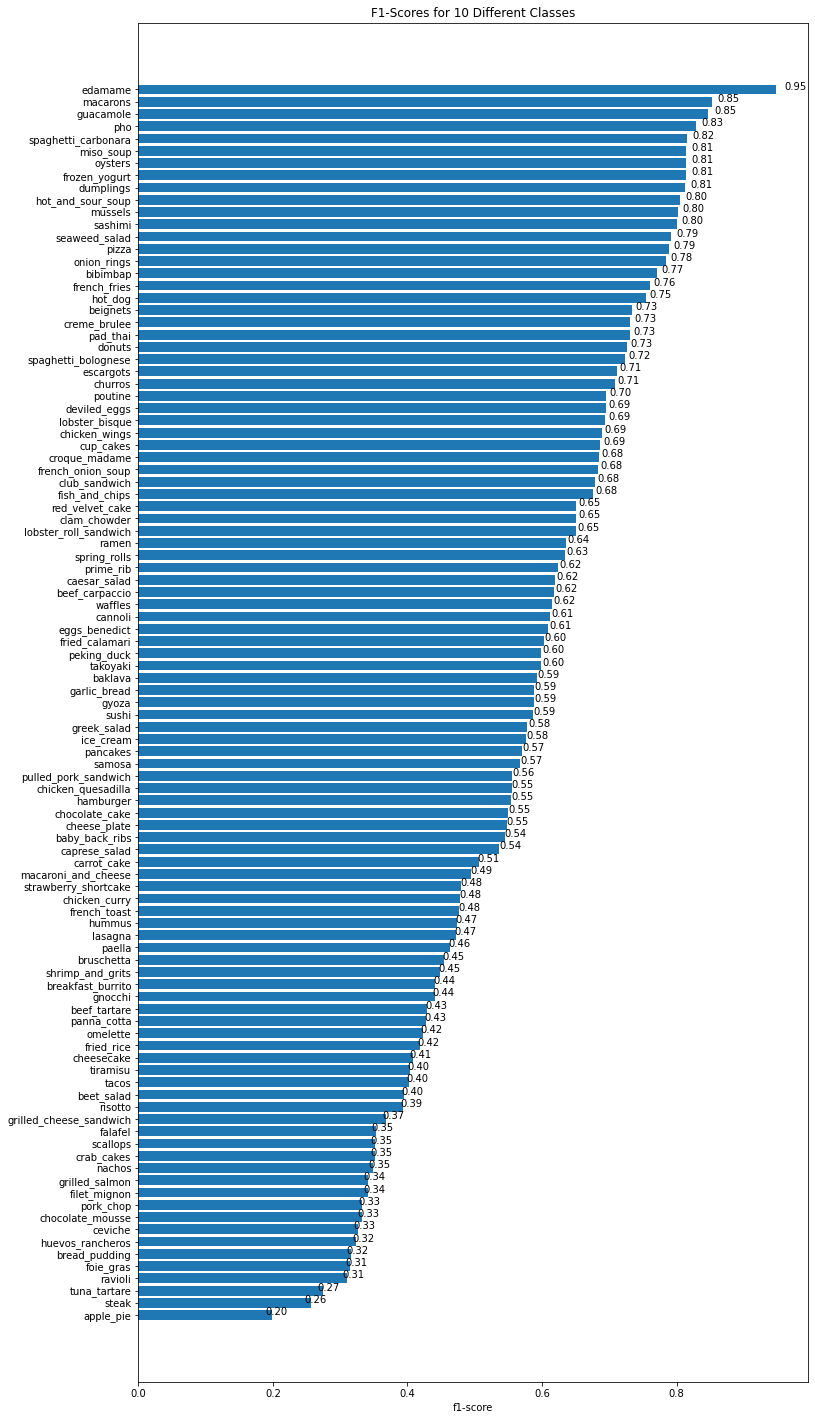

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1_score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

#Visualizing predictions on test images
The predictions cannot be made to just any image. It needs to be loaded into a tensor. So before predicting, we will first create a function which can load image into a tensor

##Specifically :

* Read in a target image filepath using tf.io.read_file().
* Turn the image into a tensor using tf.io.decode_image().
* Resize the images to be the same size as the images our model has been trained on (224x224) using tf.image.resize().
* Scale the image to get all the pixel values between 0 and 1 if necessary

In [54]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img
  

#We need to write code to :
1. Load a few random images from test dataset
2. Make predictions on them.
3. Plot the orignal image along with the model's predicted label, prediction probability and ground truth label

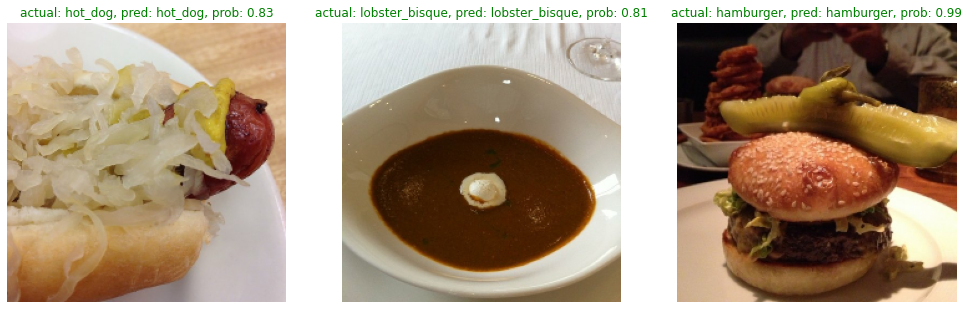

In [56]:
#Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

###After going through random images, it starts to become clear that our model is makes far more worse predictions on the images which are visually similar such as baby_back_ribs getting mistaken as steak and vice-versa

#Finding the most wrong predictions

###The most wrong predictions can give you more insight into the model's performace

1. Get all of the image file paths in the test dataset using list_files() method.
2. Create a pandas dataframe of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
 Note : We are using dataframe only to visualize in a better way
3. Use our dataframe to find wrong predictions
4. Sort the dataframe based on wrong predictions and highest max prediction probabilities.
4 Visualize the images with the highest prediction probabilties but have the wrong prediction

In [59]:
# 1. Get filenames of all of our testdata

filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

#Now we can combine then into one DataFrame
 
* Their ground truth labels (y_labels)
* The class the model predicted (pred_classes).
* The maximum prediction probability value (pred_probs.max(axis=1)).
* The ground truth class names.
* The predicted class names


In [61]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  ...  y_pred_classname
0  b'101_food_classes_10_percent/test/apple_pie/1...  ...         apple_pie
1  b'101_food_classes_10_percent/test/apple_pie/1...  ...         apple_pie
2  b'101_food_classes_10_percent/test/apple_pie/1...  ...         apple_pie
3  b'101_food_classes_10_percent/test/apple_pie/1...  ...     bread_pudding
4  b'101_food_classes_10_percent/test/apple_pie/1...  ...     bread_pudding

[5 rows x 6 columns]

### Make a simple column tell us whether or not the prediction is right or wrong 

In [62]:
# 3. Is the predictiion correct ?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'101_food_classes_10_percent/test/apple_pie/1...  ...          True
1  b'101_food_classes_10_percent/test/apple_pie/1...  ...          True
2  b'101_food_classes_10_percent/test/apple_pie/1...  ...          True
3  b'101_food_classes_10_percent/test/apple_pie/1...  ...         False
4  b'101_food_classes_10_percent/test/apple_pie/1...  ...         False

[5 rows x 7 columns]


And now since we know which predictions were right or wrong and along with their prediction probabilities, how about we get the 100 "most wrong" predictions by sorting for wrong predictions and descending prediction probabilties?

In [63]:
#Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  ...  pred_correct
23631  b'101_food_classes_10_percent/test/strawberry_...  ...         False
23797  b'101_food_classes_10_percent/test/sushi/16593...  ...         False
23935  b'101_food_classes_10_percent/test/sushi/46797...  ...         False
15826  b'101_food_classes_10_percent/test/macarons/19...  ...         False
23886  b'101_food_classes_10_percent/test/sushi/31967...  ...         False
9110   b'101_food_classes_10_percent/test/falafel/241...  ...         False
18001  b'101_food_classes_10_percent/test/pancakes/10...  ...         False
11642  b'101_food_classes_10_percent/test/garlic_brea...  ...         False
11097  b'101_food_classes_10_percent/test/fried_rice/...  ...         False
14631  b'101_food_classes_10_percent/test/ice_cream/3...  ...         False
22606  b'101_food_classes_10_percent/test/spaghetti_b...  ...         False
18510  b'101_food_classes_10_percent/test/peking_duck...  ...         False
17897  b'101_food_classes_10_percent/test/paella/2986...  ...         False
22095  b'101_food_classes_10_percent/test/seaweed_sal...  ...         False
10741  b'101_food_classes_10_percent/test/french_toas...  ...         False
21216  b'101_food_classes_10_percent/test/risotto/493...  ...         False
15359  b'101_food_classes_10_percent/test/lobster_rol...  ...         False
14300  b'101_food_classes_10_percent/test/hummus/1800...  ...         False
17816  b'101_food_classes_10_percent/test/paella/1762...  ...         False
5114   b'101_food_classes_10_percent/test/chicken_win...  ...         False

[20 rows x 7 columns]

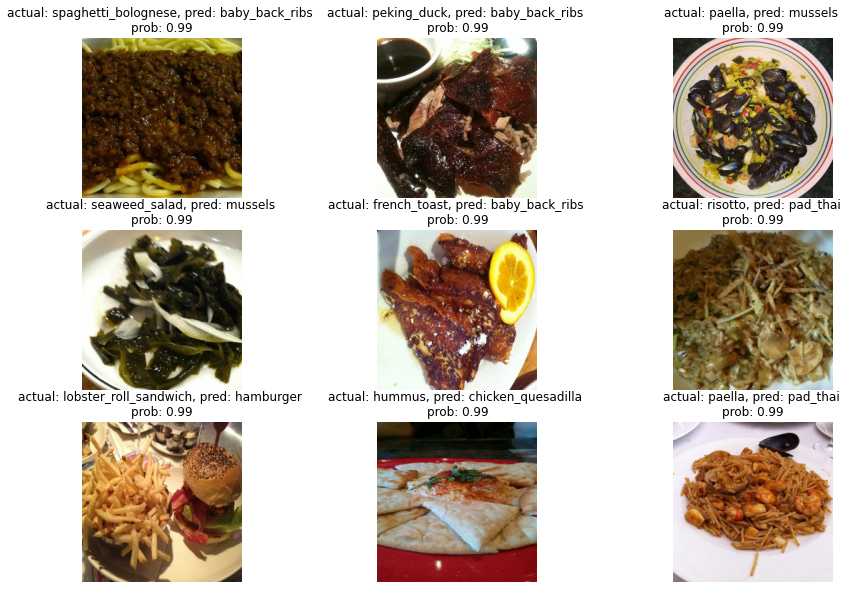

In [65]:
#Visualize the most wrong samples

images_to_view = 9
start_index = 10 #change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

#Going through model's wrong predictions, we can usually help figure out two things.

* Some of the labels might be wrong -  If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as active learning.

* Could more samples be collected ? - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

#Test out the big dog model on test images as well as custom images of food

In [66]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2021-08-19 20:58:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 172.217.219.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2021-08-19 20:58:56 (108 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [67]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg']

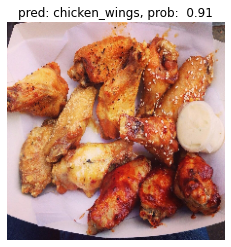

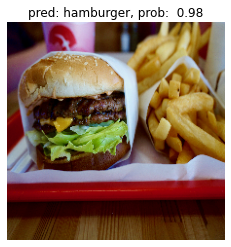

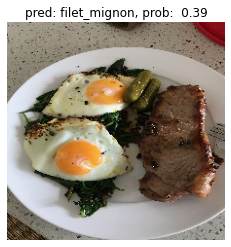

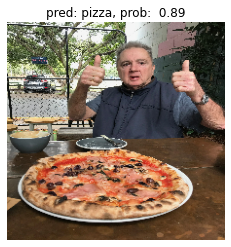

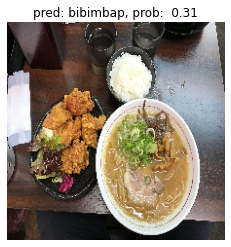

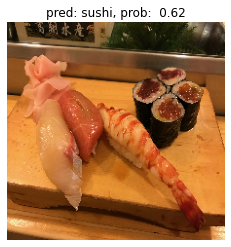

In [68]:
#Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) #load in the target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img,axis=0)) #Make predictions on image whose shape is [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] #find the predicted class label

  #Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) #imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max(): .2f}")
  plt.axis(False)